### Datascience Mini-Hackathon November 8th 2018
### Organized by MatrixDS and Bajaware


# Mexican Bank Risk:
# Forecasting Bank Risk in Mexico by state and corporate size



Author: Anne de Graaf


# Introduction
This notebook is my result for the Datascience Mini-Hackathon organized by MatrixDS and Bajaware. 
https://matrixds.com/
http://bajaware.com/

The goal of the hackathon was to predict Average Rate and the relative size of the Nonperforming Portfolio of a given dataset on loans in Mexico. The predictions had to be done by State and Corporate Size.

#### The model
The models I built are a series of simple linear regression models with L2 regularization. As interest rates are notoriously unpredictible, and as I didn't have enough time to carefully select features for my prediction model, I decided to go with a simple solution: I calculated the train set's "Average Rate" and "% Nonperforming Portfolio" per month for every combination of State and Corporate Size (same setup as the test data). Next, I made timedependent linear regression models for each of those combinations. For every combination I made two models: one for "Average Rate" and one for "% Nonperforming Portfolio".

The degree (second degree) of the fitted polynomials was chosen more-or-less at random and after I plotted a couple of different polynomials and found a second degree polynomial 'looked' to have the best fit. Regularization is quite heavy, as the train data only spans a very limited time frame. My train data for each model was very little, resulting in a high risk of overfitting (especially with the characteristic high fluctuations of interest rates).

Some combinations of State and Corporate Size were missing in the train data. For these combinations I made a model by filtering the train data only on Corporate Size, instead of both Corporate Size and State. 

I stored all the models in a nested dict, making it easy to select the right model based on State and Corporate Size. Not sure it resulted in the fastest calculations, but I was very statisfied with the structure the dict gave to my bazillion models.

Due to the limited time (which is the fun of the game) I didn't exactly follow good data science practice everywhere. At the bottom of this notebook I made some closing remarks on what I would have liked to improve about the model had I had more time. 

All used data can be found in the parent folder.

# Getting started

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

### Loading and preprocessing train data

In [2]:
data = pd.read_csv('../Corporate_Loans_Data.csv')

# Change time stamp into numerical:
data['Day'] = 1
data['DummyDate'] = pd.to_datetime(data[['Year','Month','Day']], yearfirst=True)
data = data.drop(['Month'], axis=1)
data = data.drop(['Year'], axis=1)
data = data.drop(['Day'], axis=1)
data['Date'] = (data['DummyDate'] - data['DummyDate'].min()) / np.timedelta64(1,'M')

data.head()

,Corporate Size,State,Currency,Institution,Total Portfolio,Perrformin Portfolio,Non Performing Portfolio,Percent non Performing,Number of Customers,Number of loans,Average Rate,Average Term,Average Rate Median,Average Term Median,Average Monthly Income,DummyDate,Date
0,PyME,AGUASCALIENTES,Moneda nacional,Actinver,18139219.0,18139219.0,0.0,0.0,12,12,11.80,25.91,0.00,0.00,2140427.84,2018-02-01,20.041479
1,PyME,AGUASCALIENTES,Moneda nacional,Actinver,18395095.0,18395095.0,0.0,0.0,13,13,11.62,26.03,0.00,0.00,2137510.04,2018-01-01,19.022978
2,PyME,BAJA CALIFORNIA NORTE,Moneda nacional,Actinver,25337899.0,25337899.0,0.0,0.0,3,3,12.33,24.09,0.00,0.00,3124162.95,2018-02-01,20.041479
3,PyME,BAJA CALIFORNIA NORTE,Moneda nacional,Actinver,25204074.0,25204074.0,0.0,0.0,3,3,12.16,24.09,12.16,12.16,3064815.40,2018-01-01,19.022978
4,PyME,BAJA CALIFORNIA SUR,Moneda nacional,Actinver,6030713.0,6030713.0,0.0,0.0,1,1,10.83,36.00,0.00,0.00,653126.22,2018-02-01,20.041479


In [3]:
states = data.State.unique()
corp_sizes = data['Corporate Size'].unique()
print(states) 
print(corp_sizes)

['AGUASCALIENTES' 'BAJA CALIFORNIA NORTE' 'BAJA CALIFORNIA SUR' 'CAMPECHE'
 'CHIAPAS' 'CHIHUAHUA' 'COAHUILA' 'DISTRITO FEDERAL' 'DURANGO'
 'GUANAJUATO' 'HIDALGO' 'JALISCO' 'MEXICO' 'MICHOACAN' 'MORELOS'
 'NUEVO LEON' 'OAXACA' 'PUEBLA' 'QUERETARO' 'QUINTANA ROO'
 'SAN LUIS POTOSI' 'SINALOA' 'SONORA' 'TAMAULIPAS' 'VERACRUZ' 'YUCATAN'
 'EXTRANJERO' 'COLIMA' 'NAYARIT' 'TABASCO' 'ZACATECAS' 'GUERRERO'
 'TLAXCALA']
['PyME' 'Grande' 'Fideicomiso' 'Entidades Financieras']


# Trial model

In [21]:
# Split into train and crossvalidation set:
train_data = data[data['Date']<14.0].copy()
train_data['Date2'] = train_data['Date']**2
X_train = train_data[['Date', 'Date2']].copy()
X_train = X_train.drop_duplicates(keep='first')

cross_data = data[data['Date']>14.0].copy()
cross_data['Date2'] = cross_data['Date']**2
X_cross = cross_data[['Date', 'Date2']].copy()
X_cross = X_cross.drop_duplicates(keep='first')

# print(X_train)
# print(len(data))
# print(len(train_data)+len(cross_data))

### Trial model for "mean rate" prediction

In [22]:
state = 'AGUASCALIENTES'
size = 'PyME'

train_state = train_data.loc[train_data['State'] == state]
train_state_size = train_state.loc[train_state['Corporate Size'] == size]

meanRate = train_state_size['Average Rate'].groupby(
    train_state_size['Date']).mean()

ridge = Ridge(alpha=5.0, fit_intercept=True, normalize=True).fit(X_train, meanRate)
cross_predict = ridge.predict(X_cross)

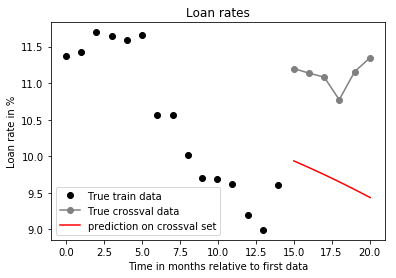

In [23]:
cross_state = cross_data.loc[cross_data['State'] == state]
cross_state_size = cross_state.loc[cross_state['Corporate Size'] == size]

meanRate_cross = cross_state_size['Average Rate'].groupby(
    cross_state_size['Date']).mean()

plt.figure()
plt.plot(X_train['Date'], meanRate, 'ko', label='True train data')
plt.plot(X_cross['Date'], meanRate_cross, 'grey', marker='o', label='True crossval data')
plt.plot(X_cross['Date'], cross_predict, '-r', label='prediction on crossval set')
plt.title('Loan rates')
plt.xlabel('Time in months relative to first data')
plt.ylabel('Loan rate in %')
plt.legend();

### Trial model for "% non performing" prediction

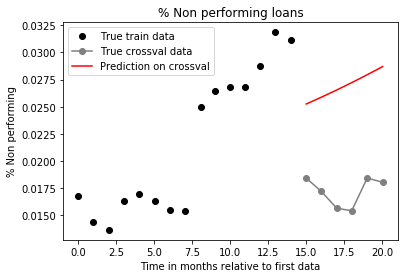

In [24]:
state = 'AGUASCALIENTES'
size = 'PyME'

train_state = train_data.loc[train_data['State'] == state]
train_state_size = train_state.loc[train_state['Corporate Size'] == size]

total = train_state_size['Total Portfolio'].groupby(
    train_state_size['Date']).sum()
nonperf = train_state_size['Non Performing Portfolio'].groupby(
    train_state_size['Date']).sum()
percentage = nonperf/total

# print(len(total), len(nonperf), len(percentage))
# print(percentage)

ridge = Ridge(alpha=5.0, fit_intercept=True, normalize=True).fit(X_train, percentage)
cross_predict = ridge.predict(X_cross)

cross_state = cross_data.loc[cross_data['State'] == state]
cross_state_size = cross_state.loc[cross_state['Corporate Size'] == size]

cross_total = cross_state_size['Total Portfolio'].groupby(
    cross_state_size['Date']).sum()
cross_nonperf = cross_state_size['Non Performing Portfolio'].groupby(
    cross_state_size['Date']).sum()
cross_percentage = cross_nonperf/cross_total

plt.figure()
plt.plot(X_train['Date'], percentage, 'ko', label='True train data')
plt.plot(X_cross['Date'], cross_percentage, 'grey', marker='o', label='True crossval data')
plt.plot(X_cross['Date'], cross_predict, '-r', label='Prediction on crossval');
plt.title('% Non performing loans')
plt.xlabel('Time in months relative to first data')
plt.ylabel('% Non performing')
plt.legend();

# Creating final models

In [25]:
data['Date2'] = data['Date']**2
X = data[['Date', 'Date2']].copy()
X = X.drop_duplicates(keep='first')

### Creating dict of models (ordered by Region and Corporation Size)

In [26]:
fit_dict = {}

for state in states:
    fit_dict[state]= {}
    for size in corp_sizes:
        
        fit_dict[state][size] = {}
        
        # take subset from data based on state and corporate size:
        sortByState = data.loc[data['State'] == state]
        sortByStateSize = sortByState.loc[sortByState['Corporate Size'] == size]
        
        # check if state/size combination is present in train set:
        if len(sortByStateSize) > 0:
            
            # create model for mean rate prediction
            dates = sortByStateSize[['Date']].copy().drop_duplicates()
            meanRate = sortByStateSize['Average Rate'].groupby(
                    sortByStateSize['Date']).mean()
            fit_dict[state][size]['rate'] = Ridge(alpha=5.0, fit_intercept=True, 
                          normalize=True).fit(dates, meanRate)

            # create model for % non perf prediction
            total = sortByStateSize['Total Portfolio'].groupby(
                    sortByStateSize['Date']).sum()
            nonperf = sortByStateSize['Non Performing Portfolio'].groupby(
                    sortByStateSize['Date']).sum()
            percentage = nonperf/total

            fit_dict[state][size]['nonperf'] = Ridge(alpha=5.0, 
                    fit_intercept=True, normalize=True).fit(dates, percentage)
        
        # if combination is not present, use the average of the Corporate Size:
        else:
            sortByCorpSize = data.loc[data['Corporate Size'] == size]
            
            # create model for mean rate prediction
            dates = sortByCorpSize[['Date']].copy().drop_duplicates()
            meanRate = sortByCorpSize['Average Rate'].groupby(
                    sortByCorpSize['Date']).mean()
            fit_dict[state][size]['rate'] = Ridge(alpha=5.0, fit_intercept=True, 
                          normalize=True).fit(dates, meanRate)

            # create model for % non perf prediction
            total = sortByCorpSize['Total Portfolio'].groupby(
                    sortByCorpSize['Date']).sum()
            nonperf = sortByCorpSize['Non Performing Portfolio'].groupby(
                    sortByCorpSize['Date']).sum()
            percentage = nonperf/total

            fit_dict[state][size]['nonperf'] = Ridge(alpha=5.0, 
                    fit_intercept=True, normalize=True).fit(dates, percentage)
        

### Making a random sanity plot

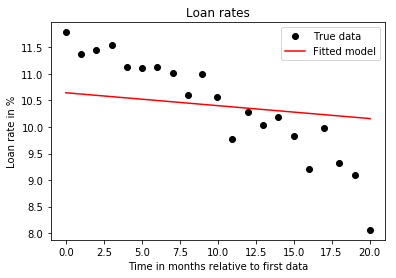

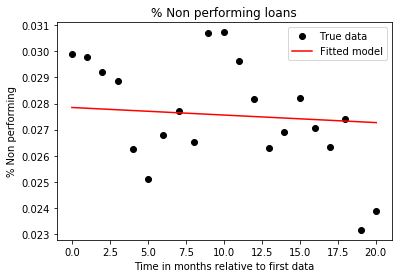

In [27]:
# sanity plot
state = 'CHIHUAHUA'
size = 'PyME'

sortByState = data.loc[data['State'] == state]
sortByStateSize = sortByState.loc[sortByState['Corporate Size'] == size]
       
dates = sortByStateSize[['Date']].copy().drop_duplicates()

# loan rates
meanRate = sortByStateSize['Average Rate'].groupby(
    sortByStateSize['Date']).mean()

model = fit_dict[state][size]['rate']
predict = model.predict(dates)

plt.figure()
plt.plot(dates, meanRate, 'ko', label='True data')
plt.plot(X['Date'], predict, '-r', label='Fitted model')
plt.title('Loan rates')
plt.xlabel('Time in months relative to first data')
plt.ylabel('Loan rate in %')
plt.legend()

# % non performing loans
total = sortByStateSize['Total Portfolio'].groupby(
    sortByStateSize['Date']).sum()
nonperf = sortByStateSize['Non Performing Portfolio'].groupby(
    sortByStateSize['Date']).sum()
nonperforming_perc = nonperf/total

model_perc = fit_dict[state][size]['nonperf']
predict_perc = model_perc.predict(dates)

plt.figure()
plt.plot(dates, nonperforming_perc, 'ko', label='True data')
plt.plot(X['Date'], predict_perc, '-r', label='Fitted model')
plt.title('% Non performing loans')
plt.xlabel('Time in months relative to first data')
plt.ylabel('% Non performing')
plt.legend();

# Forecasting/predicting test set

### Loading and preprocessing test data

In [161]:
test_data = pd.read_csv('../agregate_test.csv')

test_data['Day'] = 1
test_data['DummyDate'] = pd.to_datetime(test_data[['Year','Month','Day']], yearfirst=True)
test_data = test_data.drop(['Day'], axis=1)
test_data['Date'] = (test_data['DummyDate'] - data['DummyDate'].min()) / np.timedelta64(1,'M')
test_data = test_data.drop(['DummyDate'], axis=1)

test_data.head()

,Month,Year,State,Corporate Size,MeanRate,PercentNonPerforming,Date
0,3,2018,AGUASCALIENTES,PyME,0,0,20.961416
1,3,2018,BAJA CALIFORNIA NORTE,PyME,0,0,20.961416
2,3,2018,BAJA CALIFORNIA SUR,PyME,0,0,20.961416
3,3,2018,CAMPECHE,PyME,0,0,20.961416
4,3,2018,CHIAPAS,PyME,0,0,20.961416


### Predicting MeanRate and PercentNonPerforming

In [164]:
prediction1 = test_data.copy()

for i in range(len(prediction1)):
    state_i = prediction1.State.iloc[i]
    size_i = prediction1['Corporate Size'].iloc[i]
    date_i = [[prediction1.Date.iloc[i]]]
    
    rateModel_i = fit_dict[state_i][size_i]['rate']
    prediction1.MeanRate.iloc[i] = rateModel_i.predict(date_i)
    
    nonperfModel_i = fit_dict[state_i][size_i]['nonperf']
    prediction1.PercentNonPerforming.iloc[i] = nonperfModel_i.predict(date_i)
    
prediction1 = prediction1.drop(['Date'], axis=1)
prediction1.to_csv('../prediction1.csv')
prediction1.head()

,Month,Year,State,Corporate Size,MeanRate,PercentNonPerforming
0,3,2018,AGUASCALIENTES,PyME,10.465758,0.021612
1,3,2018,BAJA CALIFORNIA NORTE,PyME,10.056957,0.036812
2,3,2018,BAJA CALIFORNIA SUR,PyME,10.886604,0.035915
3,3,2018,CAMPECHE,PyME,12.480983,0.087823
4,3,2018,CHIAPAS,PyME,11.973948,0.050679


# Final Remarks

Unfortunately, I don't have any time left for optimizing my models. If I would have had more time I would try:
- Optimizing the hyperparameters of my models, and evaluate the degree of the fitted polynomial (which was now chosen at random).
- Fit a model on the Average Rate, weighed by the portfolio size
- If I had a lot of extra time: make a far more sophisticated model, maybe even a neural net, that takes things like currency, institution etc. into account. Although I'm not sure it would greatly improve results.

### Thanks for an awesome time at the hackathon!